# 2020 Program demonstration

- Topic: Wildfire Perimeter mapping; satellite versus aircraft instrument observations
- Summary: This ipynb demonstrates a full run for 2019 satellite detections vs all aircraft perimeters. This is a specific input to the main program

- Overall Goals:
    - Of interest to wildfire researchers is to find a way to quantify how much “simpler” satellite fire perimeter estimates are from aircraft observations
    - While it could be possible to just take the resolution of the two products, intricacies such as swath angle, tilt, and varying topography impact the resolution of each product
    - Ultimate goal: produce a program that given a “truth” polygon and “estimate” polygon, recursively optimizes the “estimate” polygon to be the closest match to the “truth”. Outside of typical shape algorithms, apply extra factors such as topography, fuel type, etc to influence the final shape
    - Topography, fuel type, and average weather behavior have an extreme influence on fire behavior; being able to lay over datasets and possibly predict corrections could help adjust future satellite products
    
- Considerations/challeneges:
    - Date matching
    - Satellite has no name sorting officially in the API
    - Cannot always assume its aircraft method
    - NIFC / fire management database is imperfect in labeling/geometry sorting


## About the Data + Files
See main ipynb

In [1]:
import sys
import os

from satellite import SatelliteDetection
from aircraft import AircraftDetection

from search_iterator import *
from Utilities import *

In [5]:
# call smart iterator with set inputs 

year_start = 2020
month_start = 6
day_start = 1

year_end = 2020
month_end = 7
day_end = 25

# 48.642283, -125.006740
# 26.522897, -77.225943


bbox = ["-125.0", "24.396308", "-66.93457", "49.384358"] # ["-122.887312", "38.560242", "-122.601345", "38.813395"] # ["-125.006740", "26.522897", "-77.225943", "48.642283"] # ["-123.894958","39.529218","-122.290878","40.634026"] # e.g. california
crs = 3857 # 4326 # recommended 

# start search
master_matches, all_aircraft_polygons, all_satellite_polygons = init_search(year_start, 
                                                                            month_start,
                                                                            day_start, 
                                                                            year_end, 
                                                                            month_end,
                                                                            day_end, 
                                                                            bbox,
                                                                            crs)

You may see an ERROR 1 occur; ignore this unless block throws actual exception...
You may see WARNING:fiona.ogrext:Expecting property name enclosed in double quotes: line 1 column 2 (char 1); you can ignore this error safely
DEBUG in __fetch_api_collection: extent / meta data: {'spatial': {'bbox': [[-125.01170994228654, 31.67479552365894, -100.99882037044597, 49.5160148262177]], 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}, 'temporal': {'interval': [['2018-01-02T12:00:00+00:00', '2021-12-31T12:00:00+00:00']], 'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}}


ERROR:fiona._env:fread(635) failed on DBF file.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.


## Printing and Plotting Sample results

Listed `master_matches` which represent indices for the following sets:
- all_aircraft_polygons
- all_satellite_polygons

## Post-data processing (lining up indices and fetching successful matches)

Print the index pairs for the two datasets (satellite, aircraft) match, along with some extra index mapping mechanisms

In [6]:
# iterate and capture only tuples best matching
non_nones = []
corresponding_indices = []

for val_set in master_matches:
    get_tuple = val_set[0]
    check = get_tuple[1]
    if check is None:
        continue
    else:
        index_extract = all_satellite_polygons.iloc[val_set[0][0]]['index']
        corresponding_indices.append(index_extract)
        non_nones.append(get_tuple)
        
# print(non_nones)
# print(corresponding_indices)

final_index_pairs  = [(replace, original[1]) for replace, original in zip(corresponding_indices, non_nones)]

print('final index pairs, fixed to proper metadata')
print(final_index_pairs)

final index pairs, fixed to proper metadata
[(2942, 15194), (2898, 15063), (2742, 5072), (2983, 4968), (2835, 4953), (3163, 4989), (3120, 4955), (3078, 5039), (3005, 5007), (2701, 5081), (2682, 5130)]


## Plot Entire Datasets against each other (full US extent)

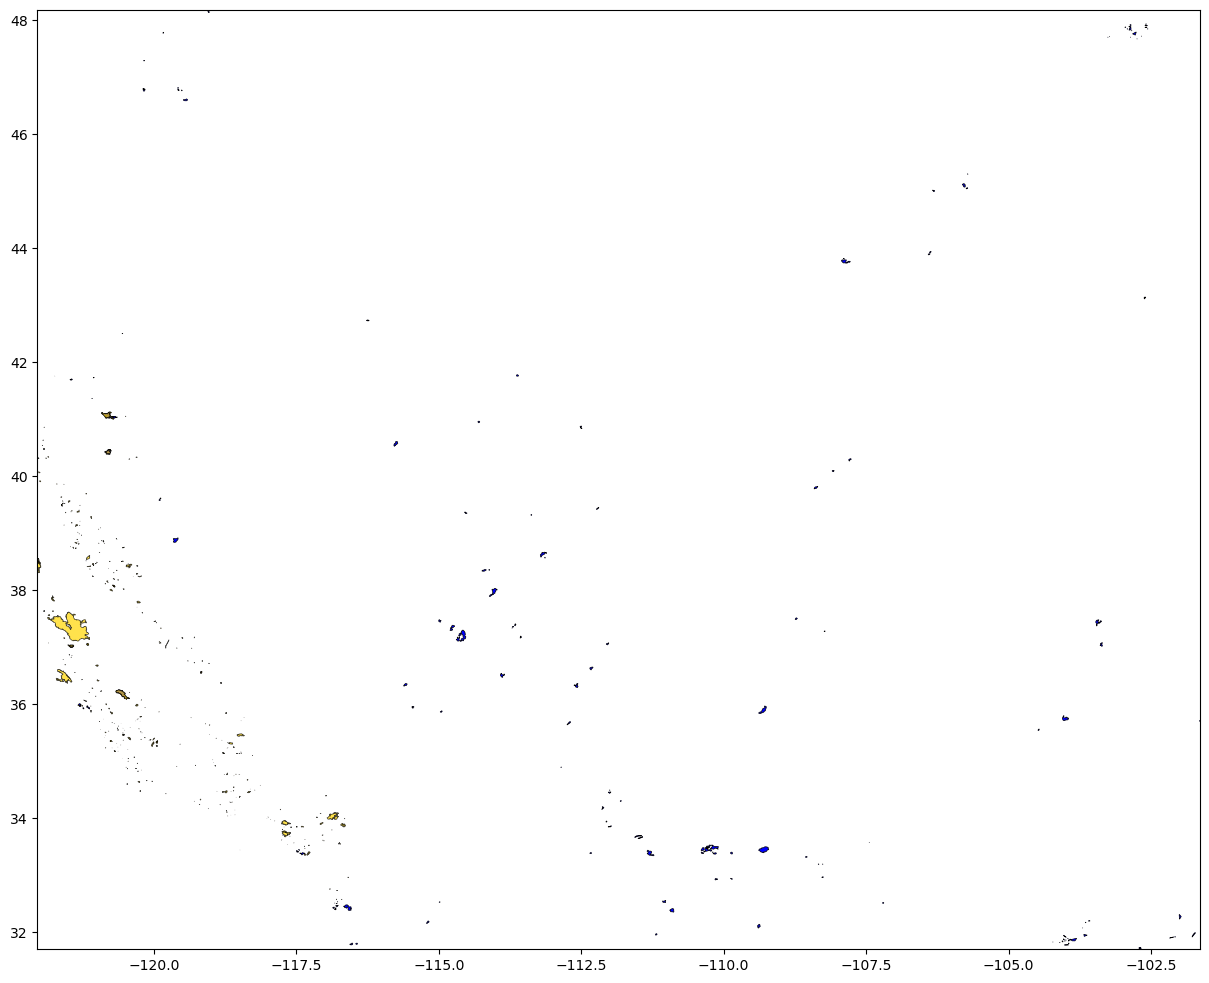

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

all_satellite_polygons.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

xmin, ymin, xmax, ymax = all_satellite_polygons.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

## Plot explicit matches by indexes

SATELLITE META DATA
                                               geometry  duration     farea  \
2942  POLYGON ((-120.534 35.452, -120.534 35.452, -1...       0.0  0.706302   

     fireid  flinelen    fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
2942  F7581  3.116949  3.116949    7.855            4         4   105467   

        pixden                    t  index  
2942  5.663296  2020-06-01T12:00:00   2942  


AIRCRAFT META DATA
       OBJECTID MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
15194     15195       None  20200605     None   6241    None   

             UNQE_FIRE_ FIRE_YEAR LOCAL_NUM              INCIDENT UNIT_ID  \
15194  2020-CASLU-11356      2020     11356  2020 Webster Burning   CASLU   

      POO_RESP_I       FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  \
15194       None  Prescribed Fire   566.9622      None  CalFire FRAP    CDF   

       FIRE_YEAR_    Shape__Are    Shape__Len  \
15194      2020.0  3.465922e+06  19026.489974   

               

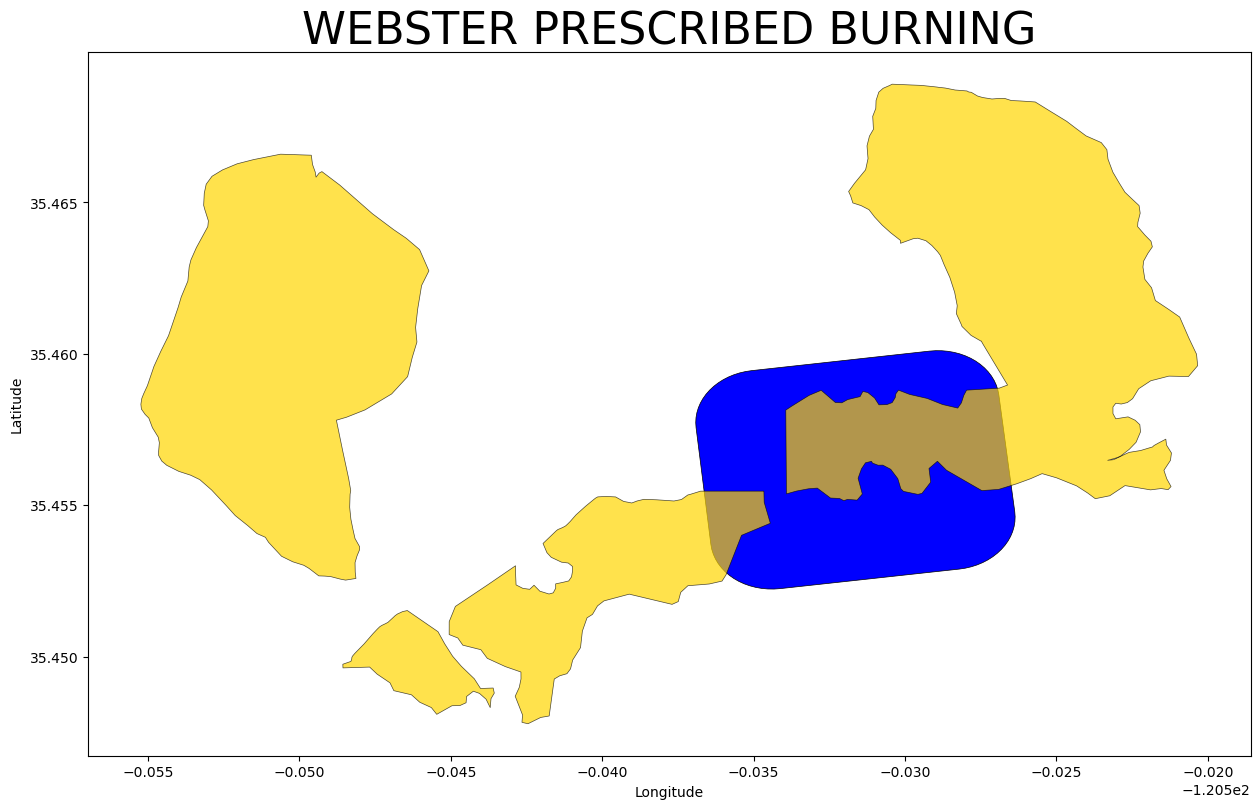

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))


sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[0][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[0][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

ax.set_title("WEBSTER PRESCRIBED BURNING", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

SATELLITE META DATA
                                               geometry  duration      farea  \
2898  MULTIPOLYGON (((-121.281 35.981, -121.281 35.9...      11.0  16.930865   

     fireid  flinelen     fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
2898  F7780       0.0  27.009469      0.0            0        72   105299   

        pixden                    t  index  
2898  4.252588  2020-07-02T12:00:00   2898  


AIRCRAFT META DATA
       OBJECTID MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
15063     15064       None  20200614     None   6174    None   

             UNQE_FIRE_ FIRE_YEAR LOCAL_NUM        INCIDENT UNIT_ID  \
15063  2020-CABEU-11067      2020     11067  Man Field Burn   CABEU   

      POO_RESP_I       FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  \
15063       None  Prescribed Fire   626.2555      None  CalFire FRAP    OTH   

       FIRE_YEAR_    Shape__Are    Shape__Len  \
15063      2020.0  3.877773e+06  11340.394258   

                       

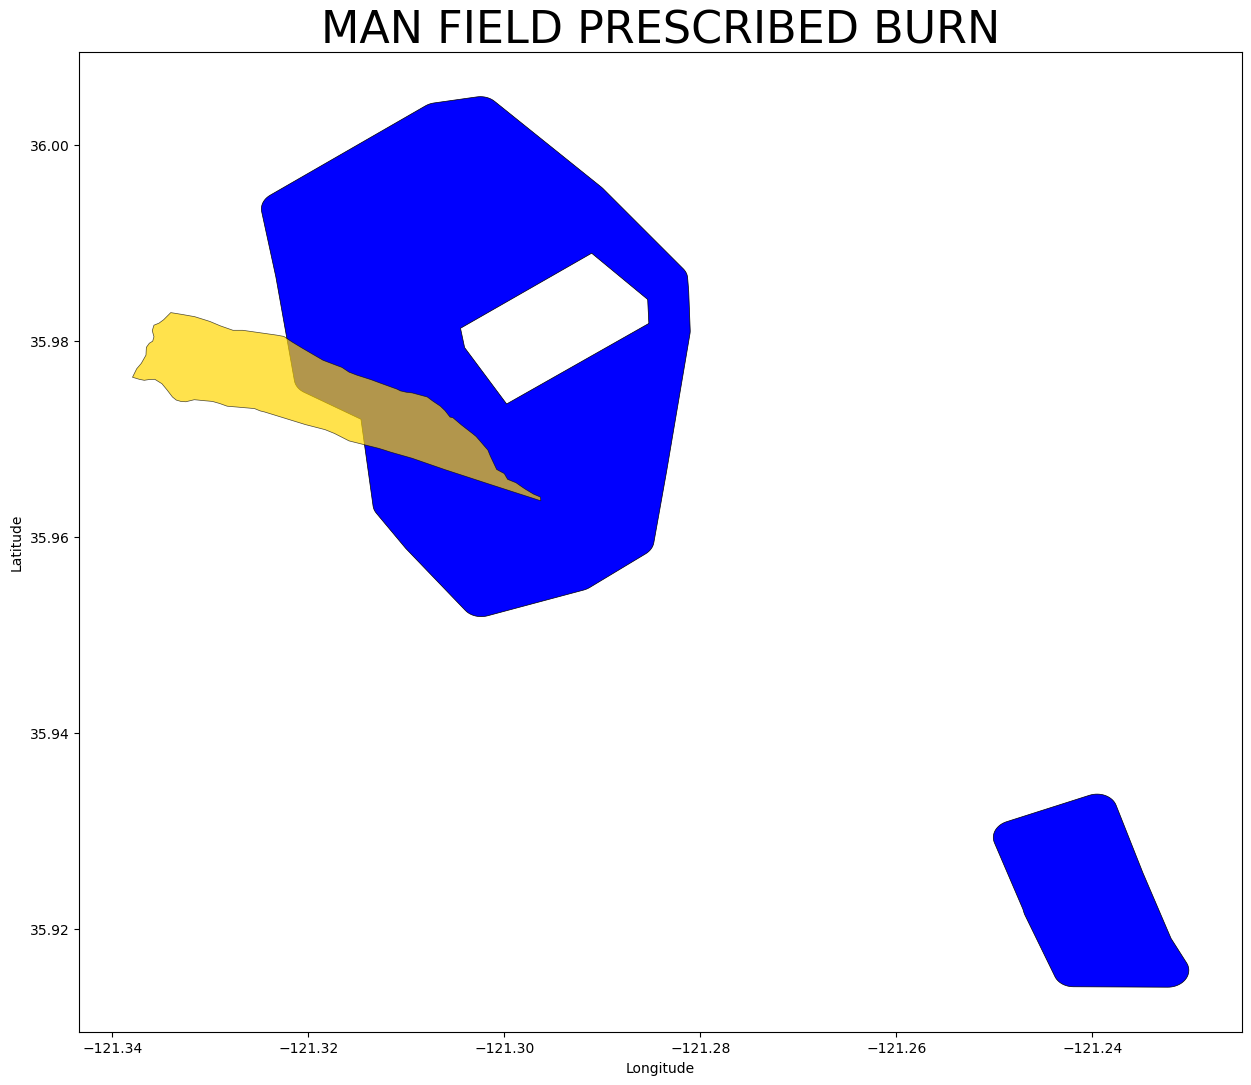

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[1][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[1][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

ax.set_title("MAN FIELD PRESCRIBED BURN", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration     farea  \
2742  POLYGON ((-122.018 38.490, -122.018 38.490, -1...       0.0  6.730286   

     fireid  flinelen    fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
2742  F7863       0.0  11.83836      0.0            0        28   103371   

        pixden                    t  index  
2742  4.160299  2020-06-10T00:00:00   2742  


AIRCRAFT META DATA
      OBJECTID                MAP_METHOD  DATE_CUR  \
5072      5073  Mixed Collection Methods  20200916   

                               COMMENTS GEO_ID IRWINID           UNQE_FIRE_  \
5072  Part of the LNU LIGHTNING COMPLEX  21666    None  2020-CALNU-00013337   

     FIRE_YEAR LOCAL_NUM   INCIDENT UNIT_ID POO_RESP_I FEATURE_CA  GIS_ACRES  \
5072      2020  00013337  HENNESSEY   CALNU       None   Wildfire   305351.9   

     USER_NAME        SOURCE AGENCY  FIRE_YEAR_    Shape__Are    Shape__Len  \
5072      None  CalFire FRAP    CDF      2020.0  

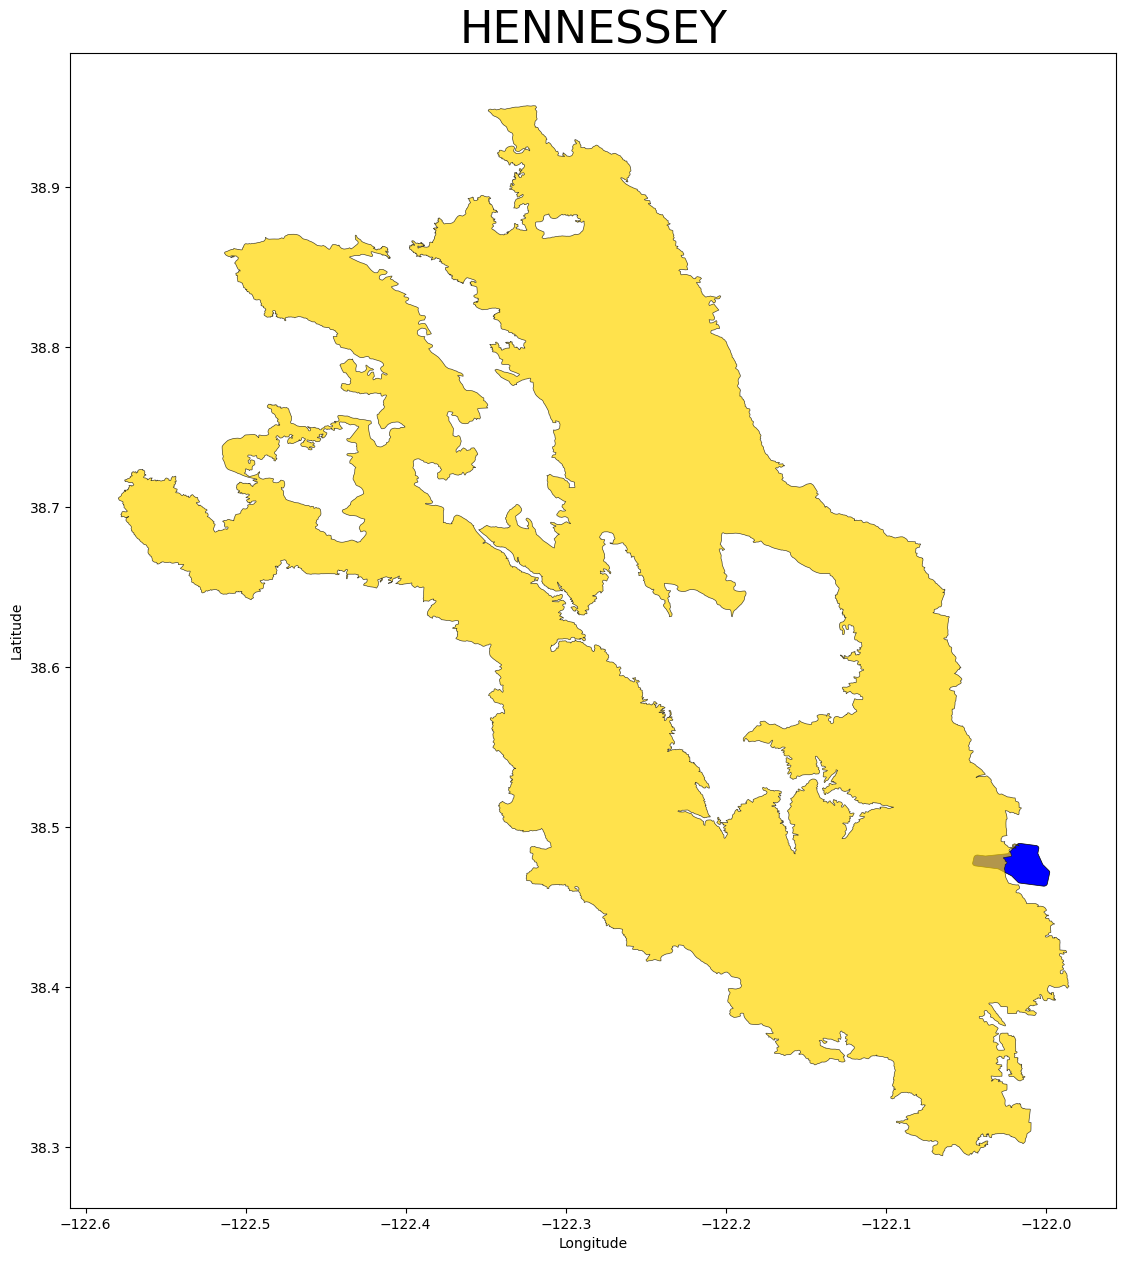

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[2][0]]
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[2][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("HENNESSEY", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration     farea  \
2983  POLYGON ((-119.950 35.320, -119.950 35.320, -1...       0.0  4.752806   

     fireid  flinelen     fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
2983  F8083       0.0  10.803915      0.0            0        15   105682   

        pixden                    t  index  
2983  3.156031  2020-06-20T00:00:00   2983  


AIRCRAFT META DATA
      OBJECTID  MAP_METHOD  DATE_CUR         COMMENTS GEO_ID IRWINID  \
4968      4969  Hand Drawn  20200610  Dragging Chains  21541    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
4968  2020-CASLU-00007149      2020  00007149     SODA   CASLU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
4968   Wildfire   1653.114      None  CalFire FRAP    CDF      2020.0   

        Shape__Are    Shape__Len  \
4968  1.007381e+07  19675.849488   

                                   

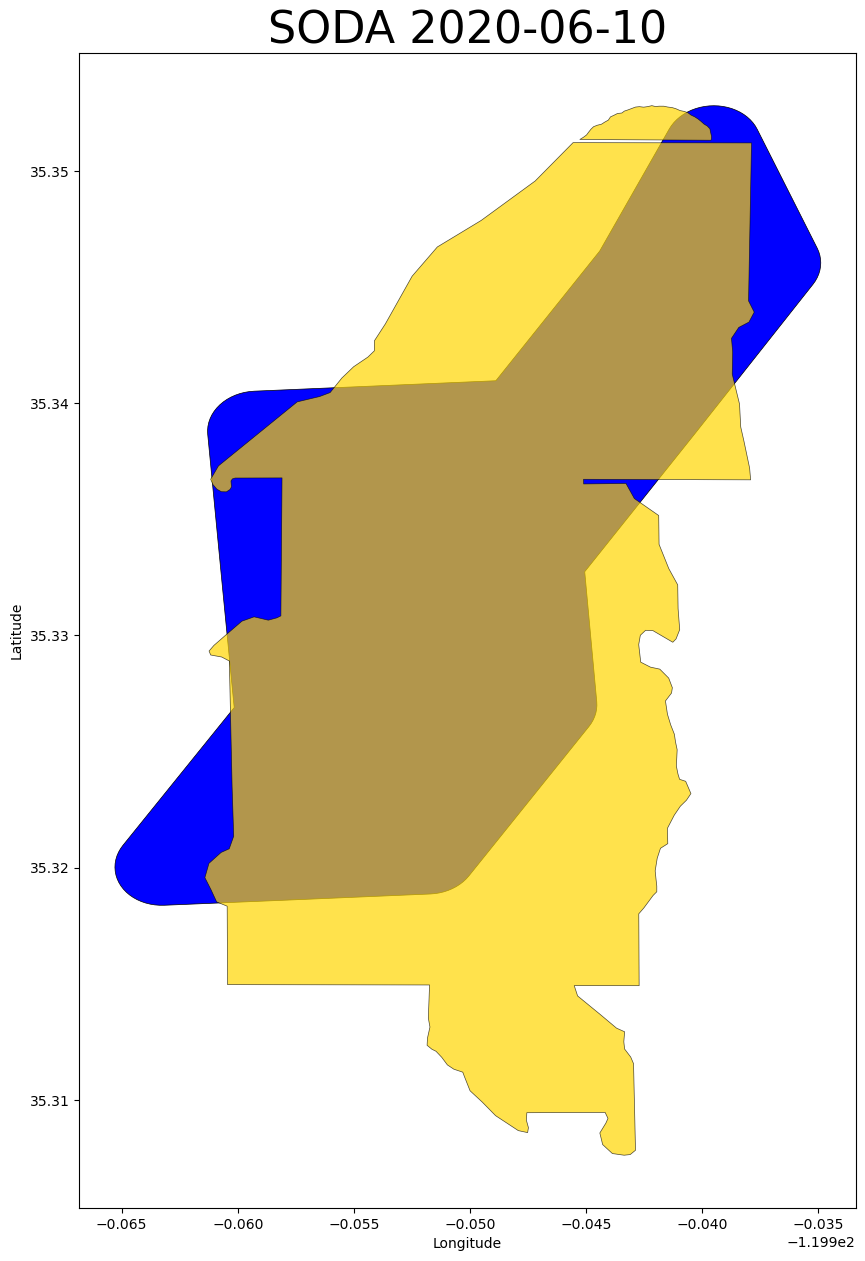

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[3][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[3][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("SODA 2020-06-10", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration     farea  \
2835  POLYGON ((-120.708 38.062, -120.712 38.066, -1...       0.0  5.675629   

     fireid  flinelen     fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
2835  F8390       0.0  10.010317      0.0            0        30   104419   

        pixden                    t  index  
2835  5.285757  2020-06-21T00:00:00   2835  


AIRCRAFT META DATA
      OBJECTID MAP_METHOD  DATE_CUR          COMMENTS GEO_ID IRWINID  \
4953      4954    GPS Air  20200623  Cause = Grinding  21499    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
4953  2020-CATCU-00006494      2020  00006494   WALKER   CATCU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
4953   Wildfire   1398.004      None  CalFire FRAP    CDF      2020.0   

        Shape__Are    Shape__Len  \
4953  9.143298e+06  19226.903666   

                                   

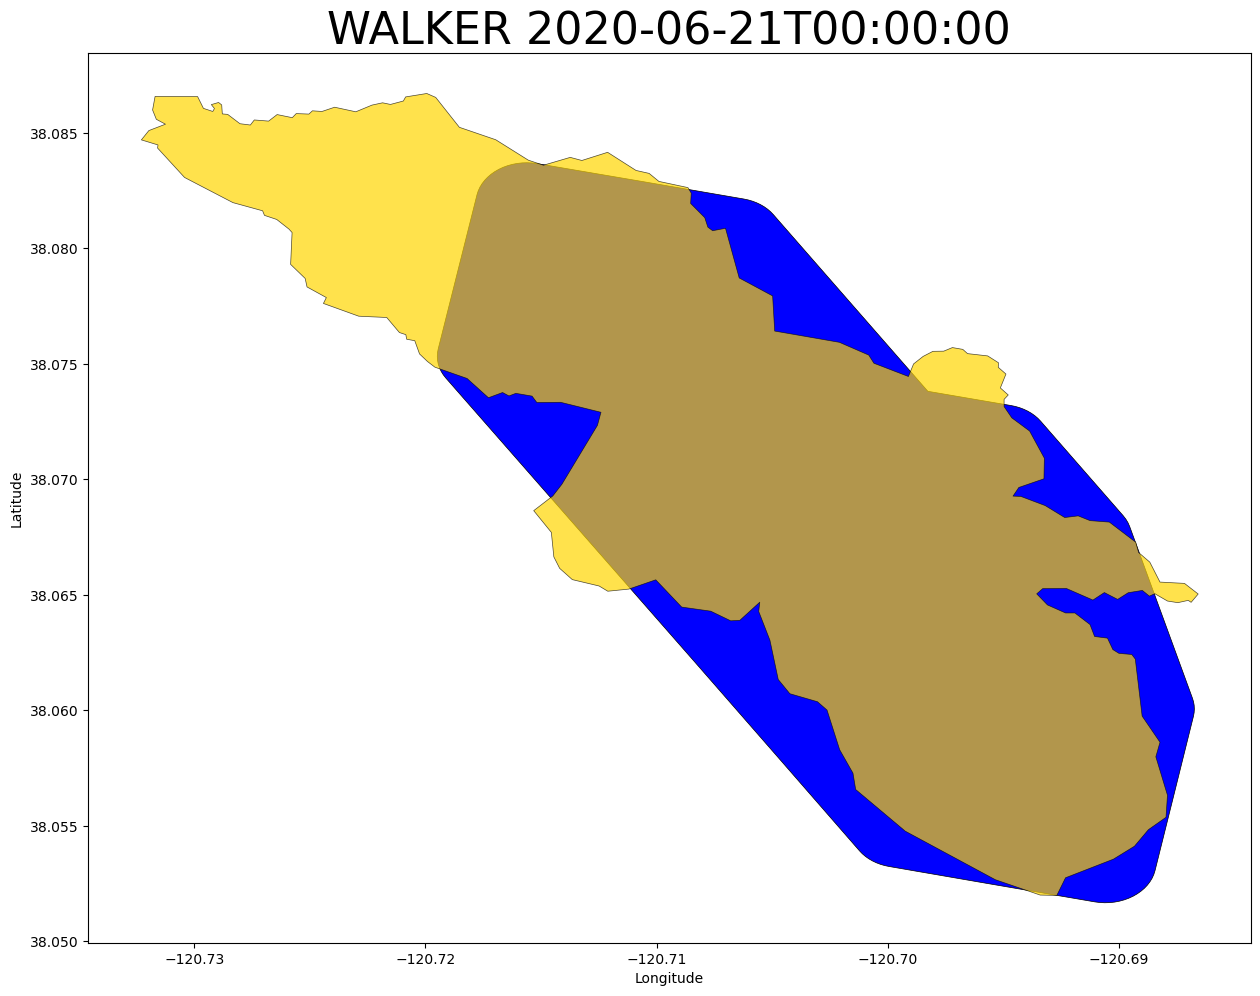

In [18]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[4][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[4][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("WALKER 2020-06-21T00:00:00", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration     farea  \
3163  POLYGON ((-119.181 36.564, -119.181 36.564, -1...       1.0  5.391365   

     fireid  flinelen    fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
3163  F8612       0.0  8.959131      0.0            0        44   106764   

        pixden                    t  index  
3163  8.161199  2020-07-07T00:00:00   3163  


AIRCRAFT META DATA
      OBJECTID  MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
4989      4990  GPS Ground  20200625     None  21562    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
4989  2020-CATUU-00000298      2020  00000298    GRADE   CATUU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
4989   Wildfire    1050.24      None  CalFire FRAP    CDF      2020.0   

        Shape__Are   Shape__Len  \
4989  6.599440e+06  13592.22194   

                                               geometry

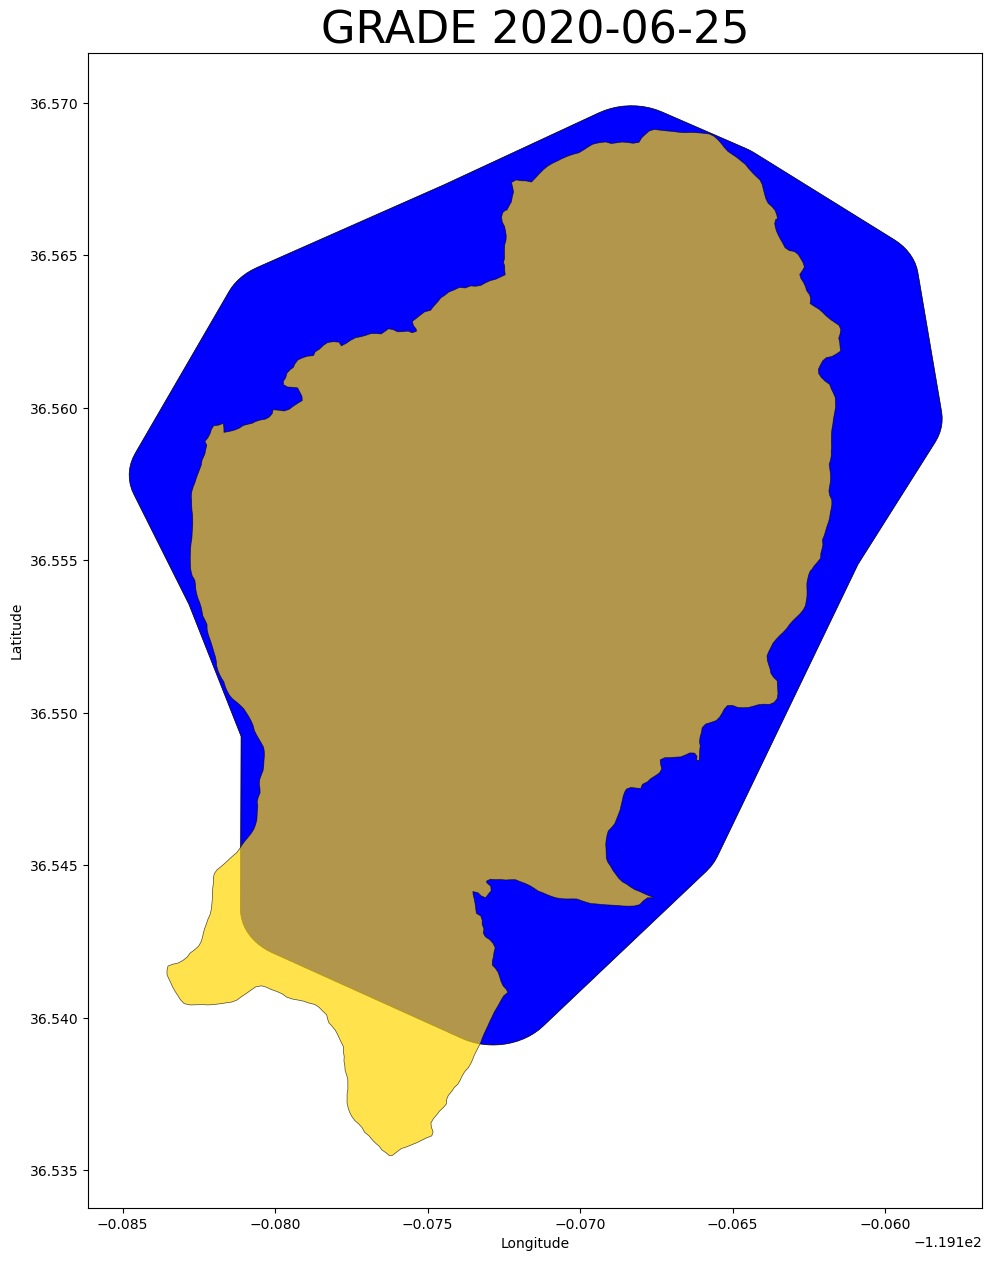

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[5][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[5][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("GRADE 2020-06-25", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration     farea  \
3120  POLYGON ((-121.165 37.033, -121.166 37.033, -1...       0.5  4.965552   

     fireid  flinelen    fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
3120  F8872       0.0  9.676184      0.0            0        18   106088   

        pixden                    t  index  
3120  3.624975  2020-07-08T12:00:00   3120  


AIRCRAFT META DATA
      OBJECTID  MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
4955      4956  GPS Ground  20200701     None  21517    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
4955  2020-CAMMU-00013431      2020  00013431     PASS   CAMMU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
4955   Wildfire   2163.698      None  CalFire FRAP    CDF      2020.0   

        Shape__Are    Shape__Len  \
4955  1.377040e+07  16695.525822   

                                               geomet

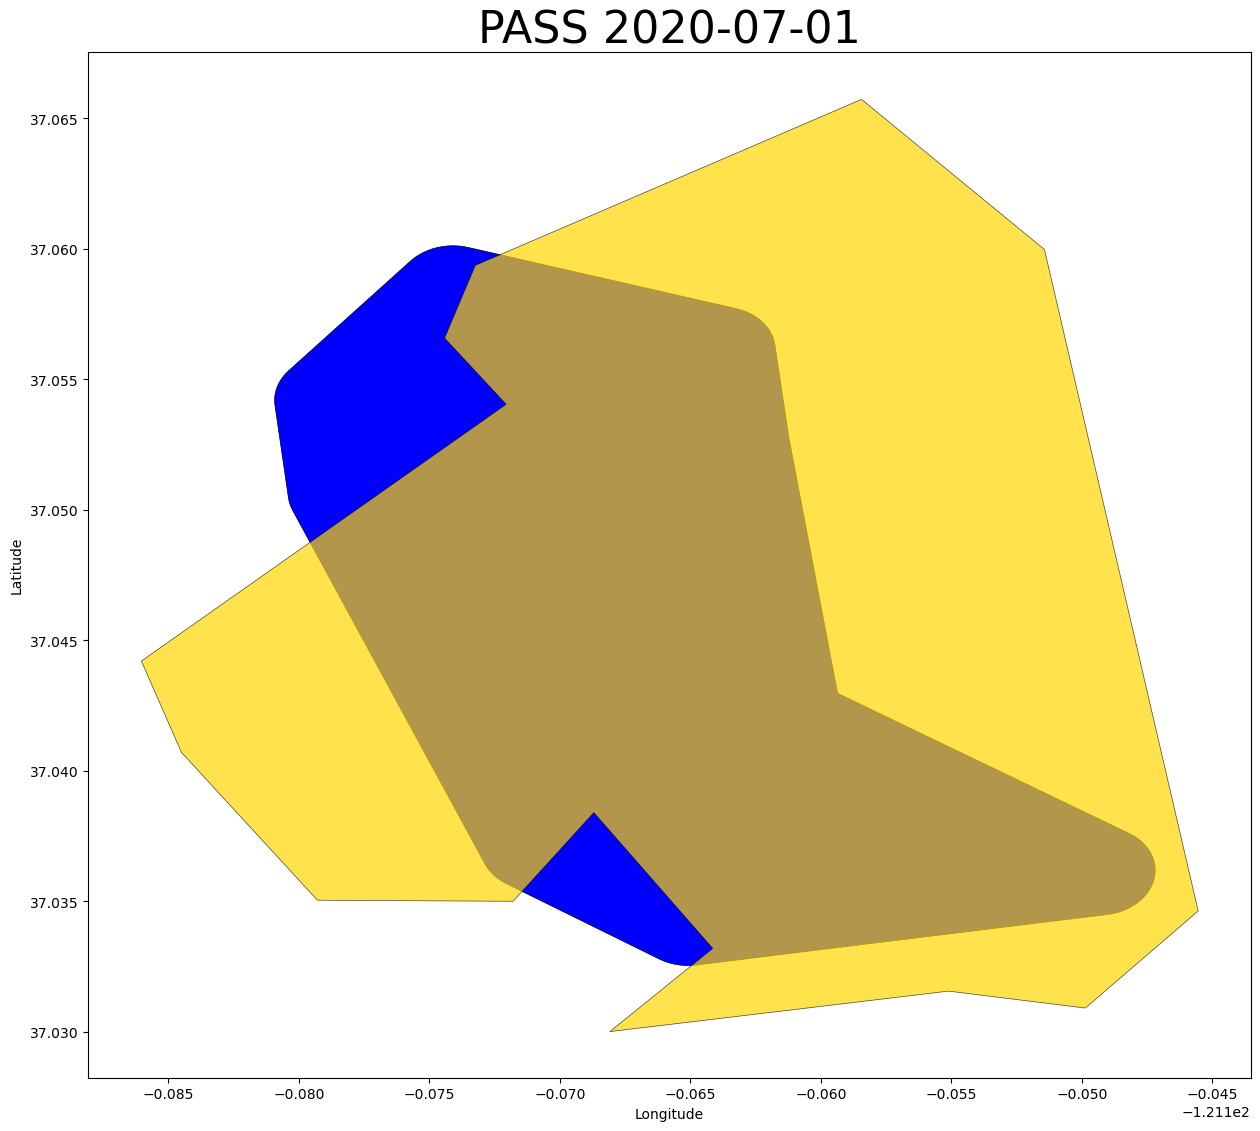

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[6][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[6][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("PASS 2020-07-01", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration      farea  \
3078  POLYGON ((-121.459 37.029, -121.459 37.029, -1...       0.0  21.445566   

     fireid   flinelen     fperim   meanfrp  n_newpixels  n_pixels  ogc_fid  \
3078  F9195  19.735375  21.078057  2.072889           90        90   106046   

        pixden                    t  index  
3078  4.196672  2020-07-06T00:00:00   3078  


AIRCRAFT META DATA
      OBJECTID MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
5039      5040    GPS Air  20200715     None  21618    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
5039  2020-CASCU-00004686      2020  00004686    CREWS   CASCU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
5039   Wildfire   5513.191      None  CalFire FRAP    CDF      2020.0   

        Shape__Are    Shape__Len  \
5039  3.506083e+07  45170.980657   

                                               

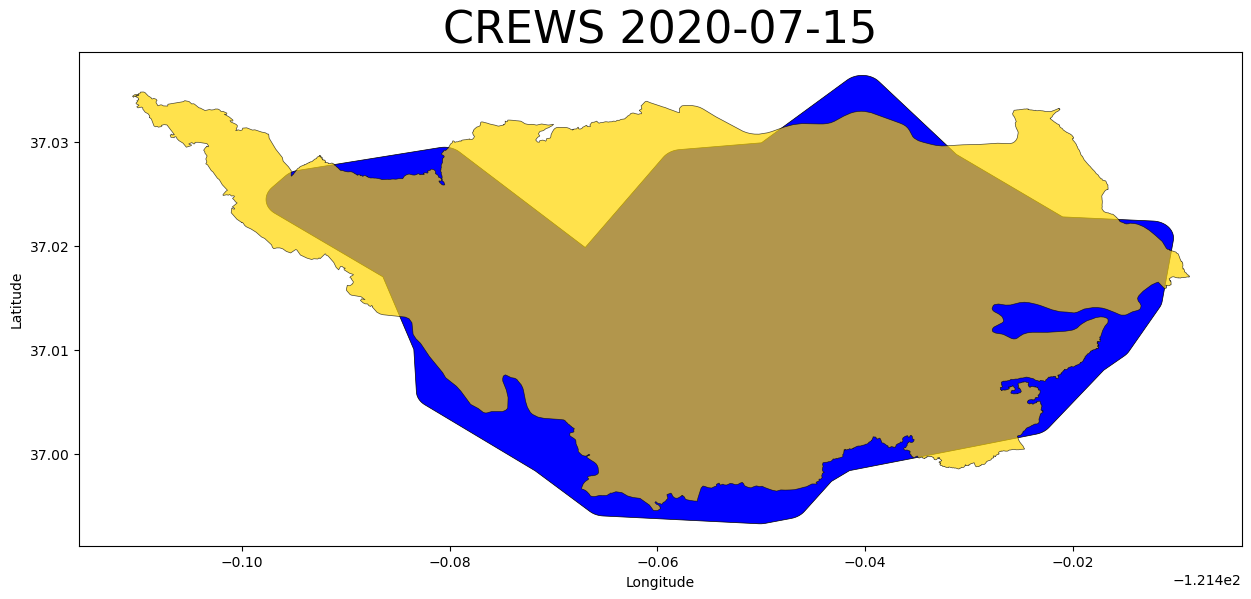

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[7][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[7][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("CREWS 2020-07-15", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration       farea  \
3005  POLYGON ((-120.510 36.150, -120.510 36.150, -1...       6.5  118.363033   

     fireid  flinelen     fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
3005  F9634       0.0  72.096432      0.0            0       633   105825   

        pixden                    t  index  
3005  5.347954  2020-07-21T12:00:00   3005  


AIRCRAFT META DATA
      OBJECTID MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
5007      5008    GPS Air  20200726     None  21580    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
5007  2020-CAFKU-00010219      2020  00010219  MINERAL   CAFKU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
5007   Wildfire   29666.96      None  CalFire FRAP    CDF      2020.0   

        Shape__Are     Shape__Len  \
5007  1.846336e+08  113981.403534   

                                               

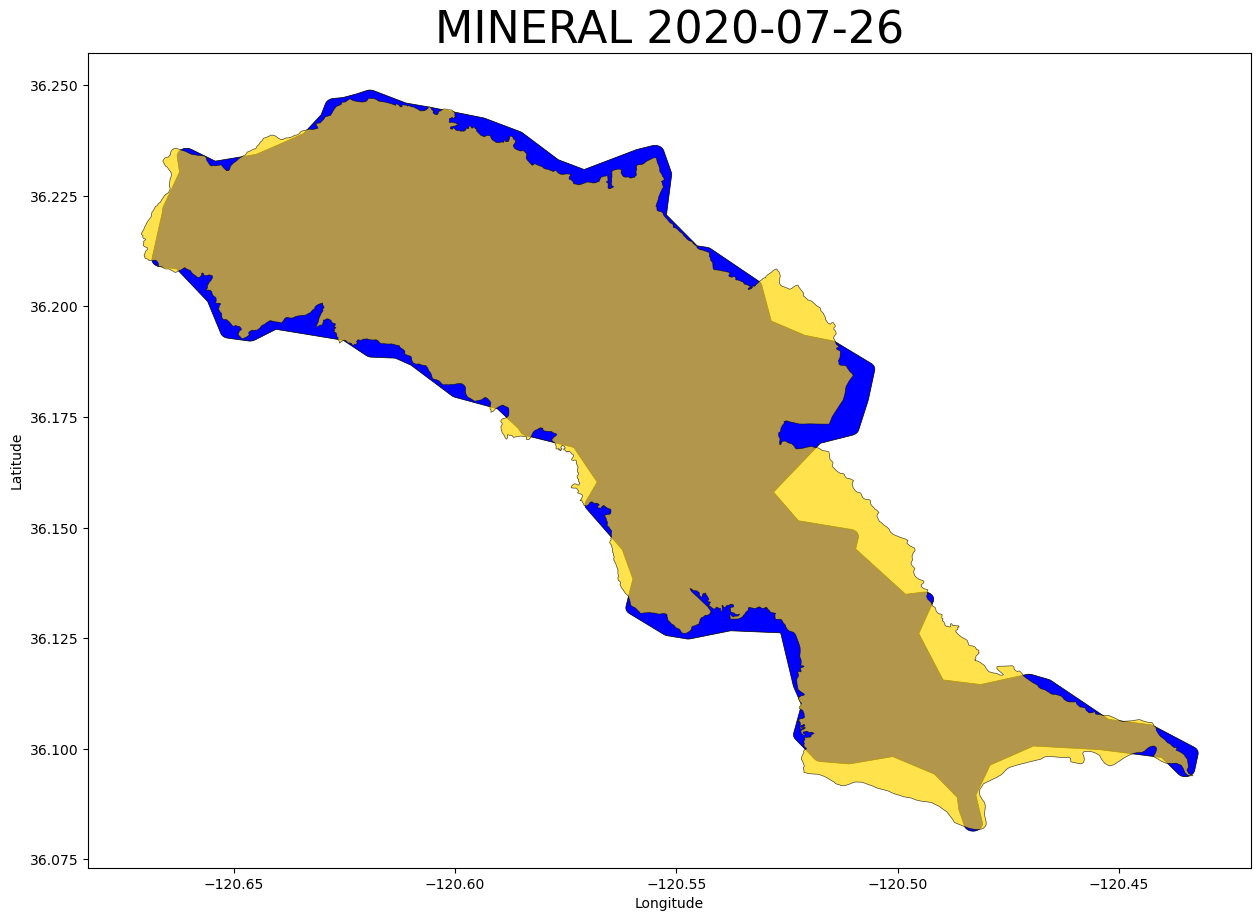

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[8][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[8][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("MINERAL 2020-07-26", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration      farea  \
2701  POLYGON ((-120.866 40.421, -120.866 40.422, -1...       4.5  49.608497   

     fireid  flinelen    fperim  meanfrp  n_newpixels  n_pixels  ogc_fid  \
2701  F9867       0.0  31.21598     6.49            4       463    97907   

        pixden                    t  index  
2701  9.333079  2020-07-23T12:00:00   2701  


AIRCRAFT META DATA
      OBJECTID                MAP_METHOD  DATE_CUR  \
5081      5082  Mixed Collection Methods  20200828   

                                  COMMENTS GEO_ID IRWINID  \
5081  795DCBB1-F228-4F7B-9C92-14999DC4B397  21745    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
5081  2020-CALMU-00003874      2020  00003874      HOG   CALMU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
5081   Wildfire    9566.36      None  CalFire FRAP    CDF      2020.0   

        Shape__Are   

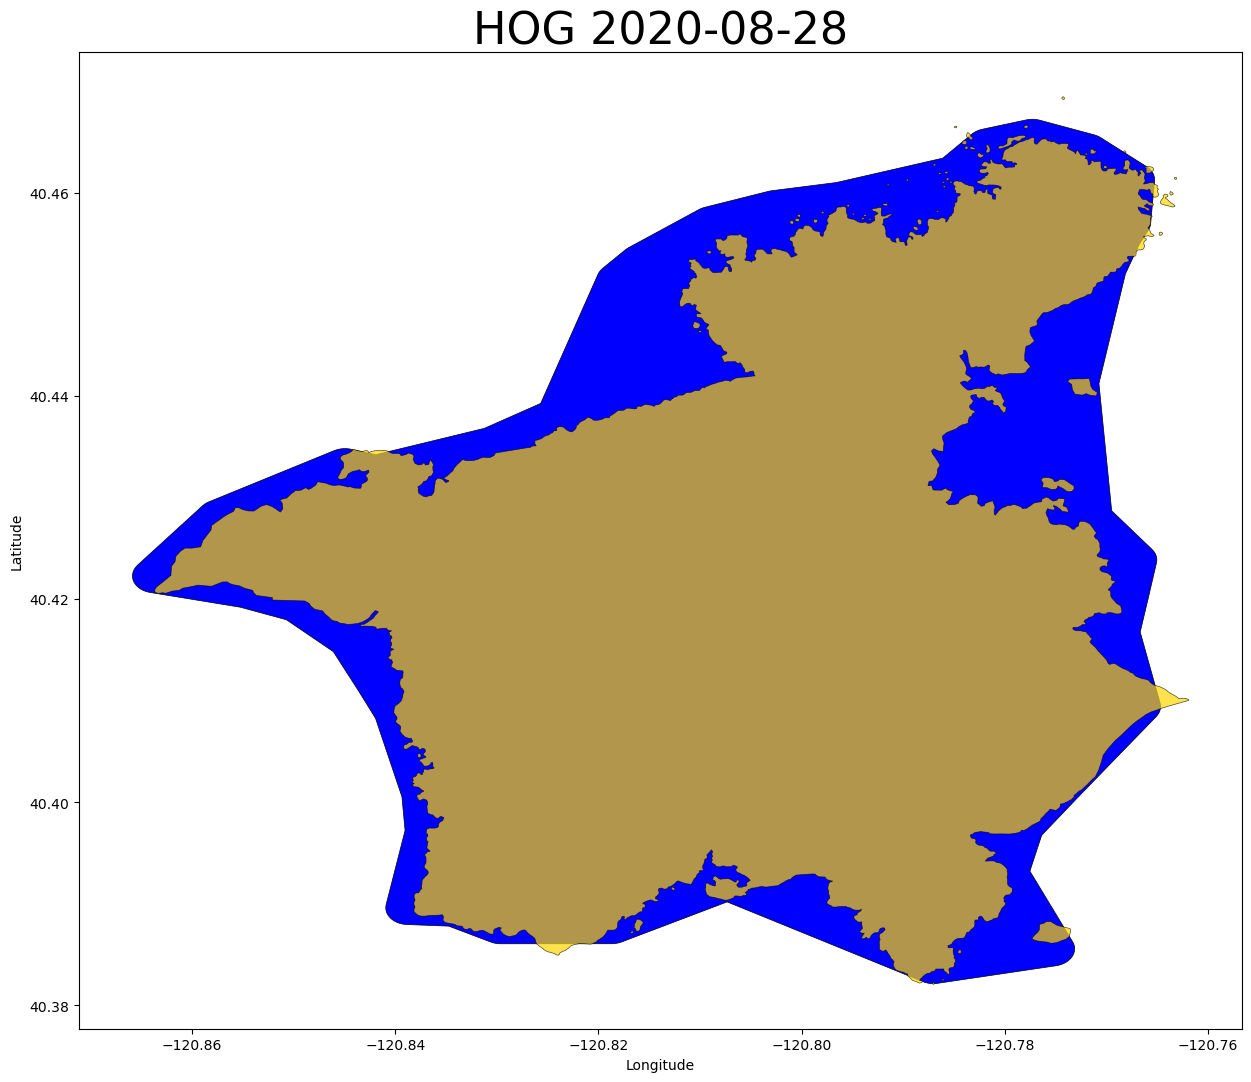

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[9][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[9][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("HOG 2020-08-28", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration       farea  \
2682  POLYGON ((-120.901 41.083, -120.901 41.083, -1...       4.0  101.241026   

     fireid  flinelen     fperim    meanfrp  n_newpixels  n_pixels  ogc_fid  \
2682  F9932  7.747614  78.030526  22.972308           52       546    96720   

        pixden                    t  index  
2682  5.393071  2020-07-24T12:00:00   2682  


AIRCRAFT META DATA
      OBJECTID                MAP_METHOD  DATE_CUR COMMENTS GEO_ID IRWINID  \
5130      5131  Mixed Collection Methods  20201029     None  21875    None   

               UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT UNIT_ID POO_RESP_I  \
5130  2020-CALMU-00003917      2020  00003917     GOLD   CALMU       None   

     FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
5130   Wildfire   22652.56      None  CalFire FRAP    CDF      2020.0   

        Shape__Are     Shape__Len  \
5130  1.614069e+08  129127.783064   

             

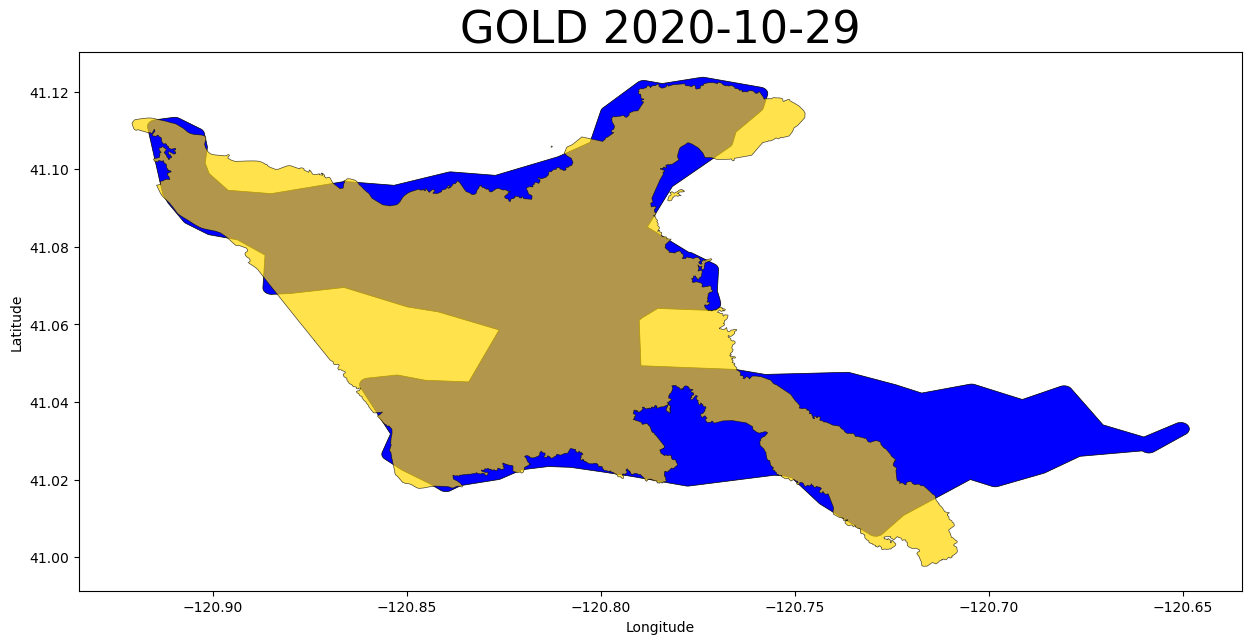

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[10][0]] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == final_index_pairs[10][1]]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("GOLD 2020-10-29", fontsize=32)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

# Part 3: Simplification per fire; find best match

For every pair of fires, run best-simplification algorithm.
Basic plan; keep simplifying and track previous results for two generations. As soon as results degrade two times in a row, go back two times and declare the best version

In [111]:
# grab kincade  
sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 7808] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11287]
# call 
result_thresh, simple_history, performance_history, tolerace_history = init_best_simplify(sat_fire, aircraft_fire, symmDiffRatioCalculation, False, 0, 2)
print(f"Best threshold value: {result_thresh}")
print(f"Index of best threshold value: {performance_history.index(max(performance_history))}")

Best threshold value: 2
Index of best threshold value: 0


### Generate an MP4 animation - Kincade

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    
    # Plot the current polygon from simple_history against aircraft_fire
    current_polygon = simple_history[frame]  # Access geometry at current index
    current_poly_plot = current_polygon.plot(ax=ax, label="SATELLITE MATCH", color="blue", edgecolor="black", linewidth=0.5)
    aircraft_fire_plot = aircraft_fire.plot(ax=ax, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
    # fetch current threshold value used
    curr_tolerance = tolerace_history[frame]
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(f'Simplification algorithm: Kincade 2019; Current Tolerance: {curr_tolerance} with best performing tolerance being: {result_thresh}')
    
    # Return the artists that change in each frame
    return [current_poly_plot, aircraft_fire_plot]
    

num_frames = len(simple_history)
ani = FuncAnimation(fig, update, frames=num_frames, interval=200)

# Save the animation as a GIF file
ani.save('polygons_animation.gif', writer='pillow', fps=10)

plt.show()

In [110]:
# TEMPORARY
import glob
import sys
import logging
import pandas as pd
import geopandas as gpd
import fsspec
import boto3
import geopandas as gpd
import datetime as dt
import logging

from pyproj import CRS
from owslib.ogcapi.features import Features
from datetime import datetime, timedelta
from botocore.exceptions import NoCredentialsError, PartialCredentialsError, EndpointConnectionError

# entry function
def init_best_simplify(sat_fire, 
                       air_fire, 
                       calc_method, 
                       lowerPref, 
                       top_performance,
                       base_tolerance
                      ):
    """ run simplify algorithm and return back best result
        use calc_method and control bool to indicate "direction" of best performance
        
        e.g. calc method symmDiffRatioCalculation(feds_poly, ref_poly)
        false since higher ratio value is better similarity
    """
    
    top_tolerance = 0
    threshold = best_simplification(sat_fire, 
                                    air_fire, 
                                    top_performance, 
                                    top_tolerance,
                                    base_tolerance,
                                    calc_method,
                                    lowerPref,
                                    [],
                                    [], 
                                    []
                                   )
    
    return threshold

def simplify_geometry(shape, tolerance):
        """ shape: to simplify
            tolerance: passed to shapely tol
            return: simplified shape
        """
        # keep preserve_topology as default (true)
        assert isinstance(shape, gpd.GeoDataFrame)
        return shape.geometry.simplify(tolerance)

def best_simplification (feds, nifc, 
                         top_performance, 
                         top_tolerance, 
                         base_tolerance, 
                         calc_method, 
                         lowerPref,
                         simple_history,
                         performance_history,
                         tolerance_history
                        ):
    """ feds: feds source
        nifc: external source to compare to
        top_performance: best numeric value (default is worst value aka > 100 % error)
        top_tolerance: corresponding simplification with best performance
        base_tolerance: counter for tracking progress from limit -> 0
        calc_method
        lowerPref: true if a "better" score is considered a lower value

        return: top_tolerance (best tolerance value from recursion)

    """
    if base_tolerance <= 0.001:
        return top_tolerance, simple_history, performance_history, tolerance_history

    # simplify + calculate performance
    simplified_feds = simplify_geometry(feds, base_tolerance)
    simple_history.append(simplified_feds)
    curr_performance = calc_method(simplified_feds, nifc)
    performance_history.append(curr_performance)
    tolerance_history.append(base_tolerance)

    # if performance "better" (depends on passed bool / method) -> persist
    if curr_performance < top_performance and lowerPref:
        top_performance = curr_performance
        top_tolerance = base_tolerance
    elif curr_performance > top_performance and not lowerPref:
        top_performance = curr_performance
        top_tolerance = base_tolerance

    # reduce and keep recursing down
    base_tolerance -= 0.002

    return best_simplification(feds, nifc, top_performance, top_tolerance, base_tolerance, calc_method, lowerPref, simple_history, performance_history, tolerance_history)

def symmDiffRatioCalculation(feds_inst, nifc_inst):
    """ symmetric difference calc, ratio 
        NOTE: error relative to NIFC/external soure
    """
    sym_diff = feds_inst.symmetric_difference(nifc_inst, align=False)
    # use item() to fetch int out of values
    assert sym_diff.shape[0] == 1, "Multiple sym_diff entries identified; pair accuracy evaluation will fail."
    # calculate error percent: (difference / "correct" shape aka nifc)
    symm_area = areaCalculation(sym_diff)
    nifc_area = areaCalculation(nifc_inst)
    # symmDiff_ratio = sym_diff.geometry.area.item() / nifc_inst.geometry.area.item()
    symmDiff_ratio = symm_area / nifc_area

    return symmDiff_ratio

def accuracyCalculation(feds_inst, nifc_inst):
    """ Calculate accuracy defined in table 6:
        (TP+TN)/AREA_TOTAL

        TN == agreed inverse by bounding box
        TP == FRAP + FEDS agree on burned (intersect)
    """
    TN = trueNeg(feds_inst, nifc_inst)
    TP = truePos(feds_inst, nifc_inst)
    AREA_TOTAL = areaTotal(feds_inst, nifc_inst)

    return (TN + TP) / AREA_TOTAL

def areaCalculation(geom_instance):
        """ Calculate area of the object, including
            mult-row instances via loop
            Input: geom data frame instance
            Output: numeric area calculation (units defined in const)
            
            # terms:
            # FEDS data are considered as the predicted class. 
            # TN: True Negative; FN: False Negative; FP: False Positive; 
            # TP: True Positive; FEDS_UB: Unburned area from FEDS; 
            # FEDS_B: Area burned from FEDS; FRAP_UB: Unburned area from FRAP; 
            # FRAP_B: Burned area from FRAP; AREA_TOTAL: Total land area in CA
        """
        try:
            area = 0
            for i in range(geom_instance.geometry.area.shape[0]):
                area += geom_instance.geometry.area[i]
        except KeyError:
            # print('Identified key error in areaCalculation(): returning item() based area calc', end='\r')
            area = geom_instance.geometry.area.item()

        return area

def areaTotal(feds_inst, nifc_inst):
    """ Calculate total Area defined in table 6:	
        FEDS_B/REF_B(burned area)
    """
    # union to envelope 
    unionr = gpd.overlay(feds_inst, nifc_inst, how='union')
    # generate bounding box fitting both instances (even if multi-poly)
    net_bounding = unionr.geometry.envelope
    net_barea = areaCalculation(net_bounding)
    # convert to data frame
    # net_bounding = net_bounding.to_frame()

    return net_barea

## Part 4: mass calculations for demo

In [39]:
# sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == final_index_pairs[10][0]

result_dict = run_calculations(final_index_pairs, all_satellite_polygons, all_aircraft_polygons)
print_output(result_dict, all_satellite_polygons)

CALCULATED A RESULT: POLYGON FEDS AT INDEX 2942 AGAINST REFERENCE POLYGON AT INDEX 15194:
Ratio: 0.30783441935099976, Accuracy: 0.5902211487428473, Precision: 0.34447986978749273, Recall: 0.10604276069414081, IOU: 0, F1 0.1621654226637704, Symmetric Ratio: 1.0957488979627241
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 2898 AGAINST REFERENCE POLYGON AT INDEX 15063:
Ratio: 6.680461915243205, Accuracy: 0.7958281553534521, Precision: 0.06770705664355142, Recall: 0.4523144133004597, IOU: 0, F1 0.1177831277055781, Symmetric Ratio: 6.775833088642138
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 2742 AGAINST REFERENCE POLYGON AT INDEX 5072:
Ratio: 0.005435921925219413, Accuracy: 0.6702501293312546, Precision: 0.24251705330652457, Recall: 0.001318303767308542, IOU: 0, F1 0.002622352630457523, Symmetric Ratio: 1.0027993143906193
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 2983 AGAINST REFERENCE POLYGON AT 

In [38]:
import glob
import sys
import logging
import pandas as pd
import geopandas as gpd
import fsspec
import boto3
import geopandas as gpd
import datetime as dt
import logging

from pyproj import CRS
from owslib.ogcapi.features import Features
from datetime import datetime, timedelta
from botocore.exceptions import NoCredentialsError, PartialCredentialsError, EndpointConnectionError

def print_output(calculations, feds_polygons):
        """ print output using the _calculations var"""
        
        for i in range(len(calculations['index_pairs'])):
            skip_first_key = True
            # per each --> print value at corresponding i index
            vals = []
            for key in calculations:
                if skip_first_key:
                    skip_first_key = False
                    continue  # Skip the first key
                vals.append(calculations[key][i])
            print(f'CALCULATED A RESULT: POLYGON FEDS AT INDEX {calculations["index_pairs"][i][0]} AGAINST REFERENCE POLYGON AT INDEX {calculations["index_pairs"][i][1]}:')
            print(f'Ratio: {vals[0]}, Accuracy: {vals[1]}, Precision: {vals[2]}, Recall: {vals[3]}, IOU: {vals[4]}, F1 {vals[5]}, Symmetric Ratio: {vals[6]}')
            print(f'All measurements in units {feds_polygons.crs.axis_info[0].unit_name}')
                                 
        return

def run_calculations(index_pairs, feds_polygons, ref_polygons):
        """ orchestrate all calculations; either return back to enable output write or write here"""
        
        calculations = { 'index_pairs': index_pairs,
                         'ratio': [],
                         'accuracy': [],
                         'precision': [],
                         'recall': [],
                         'iou': [],
                         'f1': [],
                         'symm_ratio': []
                       }
                                 
        for feds_ref_pair in index_pairs: # e.g. (4, 1) <- feds index 4 best matches with ref poly at index 1
                                 
            skip_first_key = True
                                 
            # no reference polygon --> attach none to tracked calculations
            if (feds_ref_pair[1] is None):
                for key in calculations:
                    if skip_first_key:
                        skip_first_key = False
                        continue  # Skip the first key
                    calculations[key].append(None)
                continue
           
            # fetch corresponding polygons
            feds_poly = feds_polygons[feds_polygons['index'] == feds_ref_pair[0]]
            ref_poly = ref_polygons[ref_polygons['index'] == feds_ref_pair[1]]
               
            # run through calculations
            ratio = ratioCalculation(feds_poly, ref_poly)
            accuracy = accuracyCalculation(feds_poly, ref_poly)
            precision = precisionCalculation(feds_poly, ref_poly)
            recall = recallCalculation(feds_poly, ref_poly)
            iou= IOUCalculation(feds_poly, ref_poly)
            f1 = f1ScoreCalculation(feds_poly, ref_poly) 
            symm_ratio = symmDiffRatioCalculation(feds_poly, ref_poly) # indep calc
            
            # add to tracking arr                    
            calculations['ratio'].append(ratio)
            calculations['accuracy'].append(accuracy)
            calculations['precision'].append(precision)
            calculations['recall'].append(recall)
            calculations['iou'].append(iou)
            calculations['f1'].append(f1)
            calculations['symm_ratio'].append(symm_ratio)
            
        # verify same sizing
        for key in calculations: 
            assert len(calculations[key]) == len(index_pairs), f"FATAL: mismatching sizing of arr at key {key} for calculations"
        
        return calculations
    
def areaCalculation(geom_instance):
        """ Calculate area of the object, including
            mult-row instances via loop
            Input: geom data frame instance
            Output: numeric area calculation (units defined in const)
            
            # terms:
            # FEDS data are considered as the predicted class. 
            # TN: True Negative; FN: False Negative; FP: False Positive; 
            # TP: True Positive; FEDS_UB: Unburned area from FEDS; 
            # FEDS_B: Area burned from FEDS; FRAP_UB: Unburned area from FRAP; 
            # FRAP_B: Burned area from FRAP; AREA_TOTAL: Total land area in CA
        """
        try:
            area = 0
            for i in range(geom_instance.geometry.area.shape[0]):
                area += geom_instance.geometry.area[i]
        except KeyError:
            # print('Identified key error in areaCalculation(): returning item() based area calc', end='\r')
            area = geom_instance.geometry.area.item()

        return area

def truePos(feds_inst, nifc_inst):
    """ Calculate true pos area:
        where both NIFC and FEDS burned
        return basic intersection
    """
    overlay = gpd.overlay(feds_inst, nifc_inst, how='intersection')
    result = areaCalculation(overlay) # overlay.geometry.area.item()
    return result

def falseNeg(feds_inst, nifc_inst):
    """ Calculate false negative area:
        NIFC burned but FEDS DID NOT burn (unburned needs envelope)
        make bounding -> get negative of Feds -> intersect with nifc (burning)
    """
    # union to envelope 
    unionr = gpd.overlay(feds_inst, nifc_inst, how='union')

    # generate bounding box fitting both instances (even if multi-poly)
    net_bounding = unionr.geometry.envelope
    # net_barea = areaCalculation(net_bounding)
    # convert to data frame
    net_bounding = net_bounding.to_frame()

    feds_neg = gpd.overlay(net_bounding, feds_inst, how='difference')
    result = gpd.overlay(feds_neg, nifc_inst, keep_geom_type=False, how='intersection')
    result = areaCalculation(result)

    return result

def falsePos(feds_inst, nifc_inst):
    """ Calculate false negative area:
        NIFC DID NOT burn (unburned needs envelope) but FEDS burned 
        bounding -> get negative of nifc -> intersect with feds (burning)
    """
    # union to envelope 
    unionr = gpd.overlay(feds_inst, nifc_inst, how='union')

    # generate bounding box fitting both instances (even if multi-poly)
    net_bounding = unionr.geometry.envelope
    # net_barea = areaCalculation(net_bounding)
    # convert to data frame
    net_bounding = net_bounding.to_frame()

    nifc_neg = gpd.overlay(net_bounding, nifc_inst, how='difference')

    result = gpd.overlay(nifc_neg, feds_inst, keep_geom_type=False, how='intersection')
    result = areaCalculation(result)

    return result

def trueNeg(feds_inst, nifc_inst):
    """ Calculate true negative area (agreeing on none geom)
        input: two geo dataframes
        output: area where both agree of no geom
    """

    # union to envelope 
    unionr = gpd.overlay(feds_inst, nifc_inst, how='union')

    # generate bounding box fitting both instances (even if multi-poly)
    net_bounding = unionr.geometry.envelope
    net_barea = areaCalculation(net_bounding)
    # convert to data frame
    net_bounding = net_bounding.to_frame()

    # subtract feds_inst and nifc_inst from bounding area
    feds_neg = gpd.overlay(net_bounding, feds_inst, how='difference')
    nifc_neg = gpd.overlay(net_bounding, nifc_inst, how='difference')

    # TN = calculate intersection of both "negatives"
    inter_neg = gpd.overlay(feds_neg, nifc_neg, keep_geom_type=False, how='intersection')
    result = areaCalculation(inter_neg)

    return result

def areaTotal(feds_inst, nifc_inst):
    """ Calculate total Area defined in table 6:	
        FEDS_B/REF_B(burned area)
    """
    # union to envelope 
    unionr = gpd.overlay(feds_inst, nifc_inst, how='union')
    # generate bounding box fitting both instances (even if multi-poly)
    net_bounding = unionr.geometry.envelope
    net_barea = areaCalculation(net_bounding)
    # convert to data frame
    # net_bounding = net_bounding.to_frame()

    return net_barea

def ratioCalculation(feds_inst, nifc_inst):
    """ Calculate ratio defined in table 6:	
        FEDS_B/REF_B(burned area)
    """
    # sum area (since mul entries may exist) up by calc
    feds_area = areaCalculation(feds_inst)
    nifc_area = areaCalculation(nifc_inst)

    assert feds_area is not None, "None type detected for area; something went wrong"
    assert nifc_area is not None, "None type detected for area; something went wrong"

    return feds_area / nifc_area

def accuracyCalculation(feds_inst, nifc_inst):
    """ Calculate accuracy defined in table 6:
        (TP+TN)/AREA_TOTAL

        TN == agreed inverse by bounding box
        TP == FRAP + FEDS agree on burned (intersect)
    """
    TN = trueNeg(feds_inst, nifc_inst)
    TP = truePos(feds_inst, nifc_inst)
    AREA_TOTAL = areaTotal(feds_inst, nifc_inst)

    return (TN + TP) / AREA_TOTAL

# @TODO: call percision calculation func
def precisionCalculation(feds_inst, nifc_inst):
    """ TP/FEDS_B
        TP == FRAP + FEDS agree on burned (intersect)
        FEDS_B == all burned of feds 
    """
    assert isinstance(feds_inst, pd.DataFrame) and isinstance(nifc_inst, pd.DataFrame), "Object types will fail intersection calculation; check inputs"
    # calculate intersect (agreement) -> divide
    # overlay = gpd.overlay(feds_inst, nifc_inst, how='intersection')
    TP = truePos(feds_inst, nifc_inst)
    feds_area = areaCalculation(feds_inst)

    return TP / feds_area

def recallCalculation(feds_inst, nifc_inst):
    """ TP/REF_B (nifc)
        TP == FRAP + FEDS agree on burned (intersect)
        REF_B == all burned of nifc/source
    """
    # overlay = gpd.overlay(feds_inst, nifc_inst, how='intersection')
    TP = truePos(feds_inst, nifc_inst)
    nifc_area = areaCalculation(nifc_inst)

    return TP / nifc_area

def IOUCalculation(feds_inst, nifc_inst):
    """ IOU (inter over union)
        TP/(TP + FP + FN)
    """

    # overlay = gpd.overlay(feds_inst, nifc_inst, how='intersection')
    TP = truePos(feds_inst, nifc_inst)
    FP = falsePos(feds_inst, nifc_inst) # feds + nifc agree on no burning
    FN = falseNeg(feds_inst, nifc_inst) # feds thinks unburned when nifc burned

    return 0

def f1ScoreCalculation(feds_inst, nifc_inst):
    """ 2 * (Precision * Recall)/(Precision + Recall)
    """
    precision = precisionCalculation(feds_inst, nifc_inst)
    recall = recallCalculation(feds_inst, nifc_inst)
    calc = 2 * (precision*recall)/(precision+recall)

    return calc

# @TODO: custom calc functions
def symmDiffRatioCalculation(feds_inst, nifc_inst):
    """ symmetric difference calc, ratio 
        NOTE: error relative to NIFC/external soure
    """
    sym_diff = feds_inst.symmetric_difference(nifc_inst, align=False)
    # use item() to fetch int out of values
    assert sym_diff.shape[0] == 1, "Multiple sym_diff entries identified; pair accuracy evaluation will fail."
    # calculate error percent: (difference / "correct" shape aka nifc)
    symm_area = areaCalculation(sym_diff)
    nifc_area = areaCalculation(nifc_inst)
    # symmDiff_ratio = sym_diff.geometry.area.item() / nifc_inst.geometry.area.item()
    symmDiff_ratio = symm_area / nifc_area

    return symmDiff_ratio